In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import random

seed =0
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,f1_score,recall_score,precision_score,accuracy_score

# Health Insurance Cross Sell Prediction
 
The dataset is downloaded from Kaggle: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction.

Objective: A health Insurance company has a new vehicle insurance policy to cross-sell to its policyholders. They want to know "what type of customers they should be targeting for the new policy?". And, the company wants to build a model which can predict the policyholders who will be interested in the vehicle insurance. 

The dataset will be used to train our prediction model. It contains the following information about the policyholders:
- id - Unique ID for the customer
- Gender - 	Gender of the customer
- Age - Age of the customer
- Driving_License - 0 : Customer does not have DL, 1 : Customer already has DL
- Region Code - Unique code for the region of the customer
- Previously_Insured - 	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
- Vehicle_Age - Age of the Vehicle
- Vehicle_Damage - 	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
- Annual_Premium - The amount customer needs to pay as premium in the year
- Policy_Sales_Channel - Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- Vintage - Number of Days, Customer has been associated with the company
- Response - 1 : Customer is interested, 0 : Customer is not interested

Customer and policyholder are used interchangeably in this notebook.

### Load Datasets

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
#Check for num of records and columns
df.shape

(381109, 12)

In [5]:
#Check for data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [6]:
df.describe(include='all')

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109,381109.000000,381109.000000,381109.000000,381109.000000,381109,381109,381109.000000,381109.000000,381109.000000,381109.000000
unique,NaN,2,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN
top,NaN,Male,NaN,NaN,NaN,NaN,1-2 Year,Yes,NaN,NaN,NaN,NaN
freq,NaN,206089,NaN,NaN,NaN,NaN,200316,192413,NaN,NaN,NaN,NaN
mean,190555.000000,NaN,38.822584,0.997869,26.388807,0.458210,NaN,NaN,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,NaN,15.511611,0.046110,13.229888,0.498251,NaN,NaN,17213.155057,54.203995,83.671304,0.327936
min,1.000000,NaN,20.000000,0.000000,0.000000,0.000000,NaN,NaN,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,NaN,25.000000,1.000000,15.000000,0.000000,NaN,NaN,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,NaN,36.000000,1.000000,28.000000,0.000000,NaN,NaN,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,NaN,49.000000,1.000000,35.000000,1.000000,NaN,NaN,39400.000000,152.000000,227.000000,0.000000


In [7]:
#check for null value
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [8]:
#check for duplicate based on Customer ID
df.id.duplicated().any()

False

There are 381109 records and 12 variables:
- 3 Categorical variables in 'Object' type include: 
    - Gender, Vehicle_Age, Vehicle_Damage
- 6 Categorical variables in 'Numeric' type include: 
    - Response, Previously_Insured, Driving_License, Region_Code, Policy_Sales_Channel, id
- 3 Numeric variables in 'Numeric' type include: 
    - Age, Annual_Premium, Vintage

The dataset has no missing value and no duplicated record.

### Exploratory Data Analysis

In [9]:
df['Driving_License'] = df.Driving_License.map({1:'Yes',0:'No'})
df['Previously_Insured'] = df.Previously_Insured.map({1:'Yes',0:'No'})

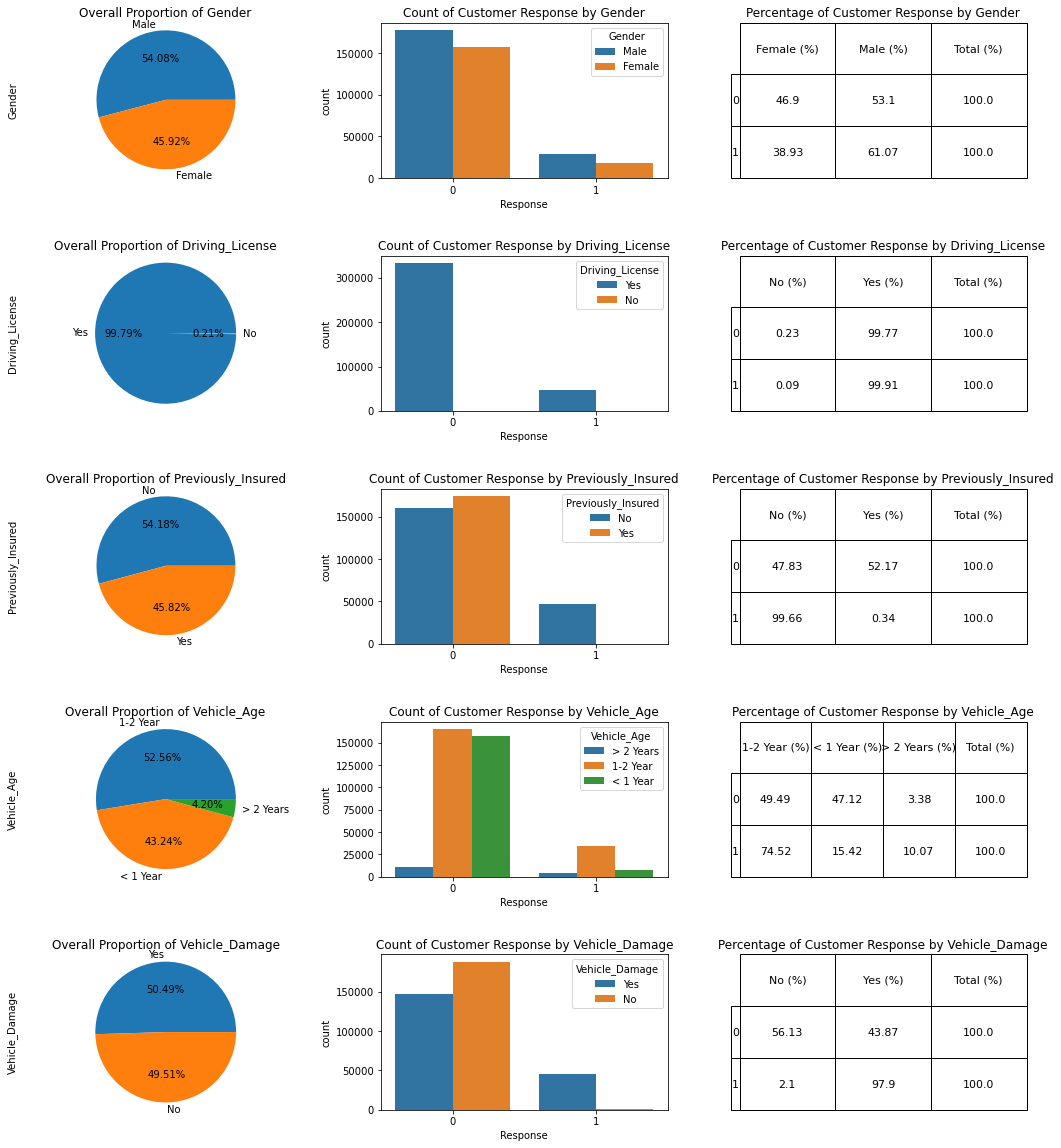

In [10]:
categorical_var = [column for column in df.columns if df[column].dtype=='O']
plt.figure(figsize=(18,20))
plt.subplots_adjust(wspace=0.25, hspace=0.5)

count=1
for i, v in enumerate(categorical_var):
    plt.subplot(5,3,i+count)
    df[v].value_counts().plot.pie(autopct='%0.2f%%',radius=1.3)
    plt.axis('equal')
    plt.title('Overall Proportion of {}'.format(v))

    count+=1
    plt.subplot(5,3,i+count)
    sns.countplot(data=df, x='Response', hue=v)
    plt.title('Count of Customer Response by {}'.format(v))
    
    count+=1
    plt.subplot(5,3,i+count)
    table=pd.crosstab(index = df.Response, columns = df[v], normalize = 'index').apply(lambda x : x*100, axis=1)
    table['Total']=table.sum(axis=1)
    table=table.round(2)
    tableplot = plt.table(cellText = table.values, rowLabels=table.index, bbox=[0,0,1,1], colLabels=table.columns+[' (%)'], cellLoc='center')
    tableplot.auto_set_font_size(False)
    tableplot.set_fontsize(11)
    plt.axis('off')
    plt.title('Percentage of Customer Response by {}'.format(v))

Main characteristics of customers who show interest (Response = 1) in buying vehicle insurance:
- Male (61% male versus 39% female)
- Having driving license (99.9% Yes versus 0.1% No)
- Do not have existing vehicle insurance (99.7% No versus 0.3% Yes)
- Vehicle aged between 1 to 2 years (75% '1-2years' versus 15% '<1year' versus 10% '>2years')
- Experienced vehicle damage in the past (98% Yes versus 2% No)

Text(0.5, 1.0, 'Top 10 Policy Sales Channel with highest Customer Response Count')

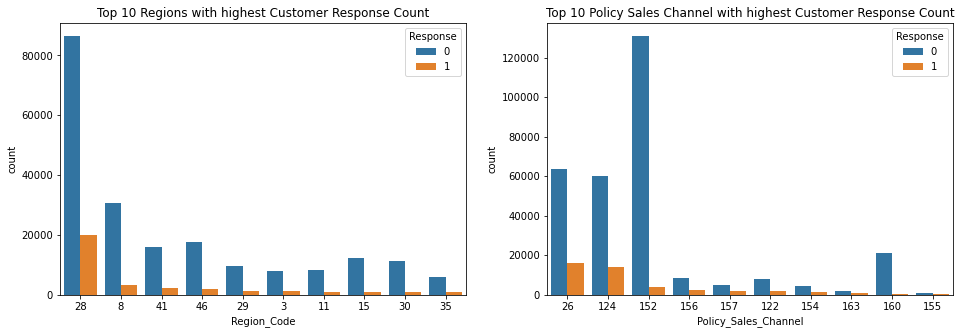

In [11]:
df['Region_Code'] = df['Region_Code'].astype('int64')
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int64')

plt.figure(figsize=(16,5))
# plot the Region_code with top 10 highest customer response
plt.subplot(1,2,1)
region_index = df[['Region_Code','Response']].value_counts().reset_index().pivot(
    columns='Response',
    index='Region_Code',
    values=0).sort_values([1,0],ascending=False).head(10).index
region_df = df[df.Region_Code.isin(region_index)]
sns.countplot(data=region_df, x='Region_Code', hue='Response', order=region_index)
plt.title('Top 10 Regions with highest Customer Response Count')

# plot the Policy_Sales_Channel with top 10 highest customer response
plt.subplot(1,2,2)
channel_index = df[['Policy_Sales_Channel','Response']].value_counts().reset_index().pivot(
    columns='Response',
    index='Policy_Sales_Channel',
    values=0).sort_values([1,0],ascending=False).head(10).index
channel_df = df[df.Policy_Sales_Channel.isin(channel_index)]
sns.countplot(data=channel_df, x='Policy_Sales_Channel', hue='Response', order=channel_index)
plt.title('Top 10 Policy Sales Channel with highest Customer Response Count')

Most of the customers who are interested (Response = 1) in buying vehicle insurance come from region_code: 28, 8, 41, 46, 29.

Most of the customers who are interested (Response = 1) in buying vehicle insurance are reached through channel_code: 26, 124, 152, 156, 157

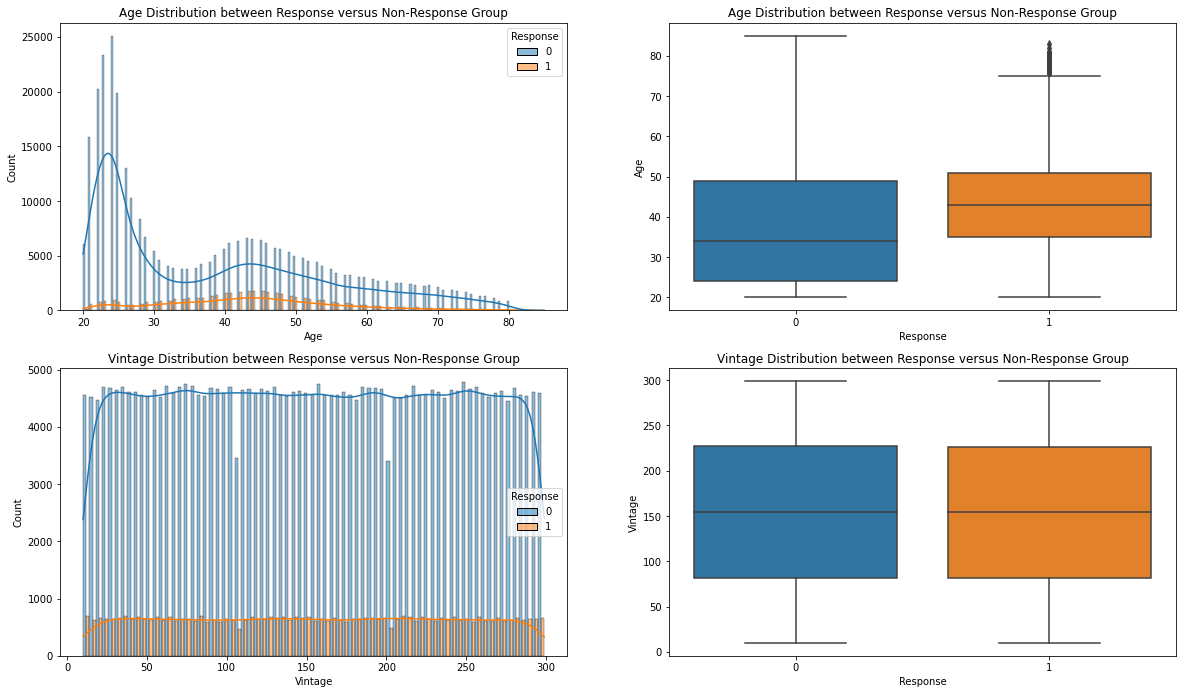

In [12]:
numeric_var = [column for column in df.columns if df[column].dtype!='O']
numeric_var = numeric_var[1:6:4]
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=0.2,hspace=0.2)

count=1
for i, v in enumerate(numeric_var):
    plt.subplot(3,2,i+count)
    sns.histplot(data=df, x=v, hue='Response',multiple='dodge', kde=True)
    plt.title('{} Distribution between Response versus Non-Response Group'.format(v))
    
    count+=1
    plt.subplot(3,2,i+count)
    sns.boxplot(data=df, x='Response', y=v)
    plt.title('{} Distribution between Response versus Non-Response Group'.format(v))

In [13]:
for col in ['Age','Vintage']:
    print(df.groupby('Response')[col].median().reset_index().rename(columns={col: 'Median {}'.format(col)}))

   Response  Median Age
0         0        34.0
1         1        43.0
   Response  Median Vintage
0         0           154.0
1         1           154.0


The age of those who are interested in buying vehicle insurance are much older (median age 43 years old) compared to those who are not interested (median age 34 years old). And, the number of days with the company (variable: Vintage) doesn't seem to affect a customer's interest in buying vehicle insurance as the median values between two groups are the same (154 days) and their distribution are overlapping.

Text(0.5, 1.0, 'Annual_Premium Distribution between Response versus Non-Response Group')

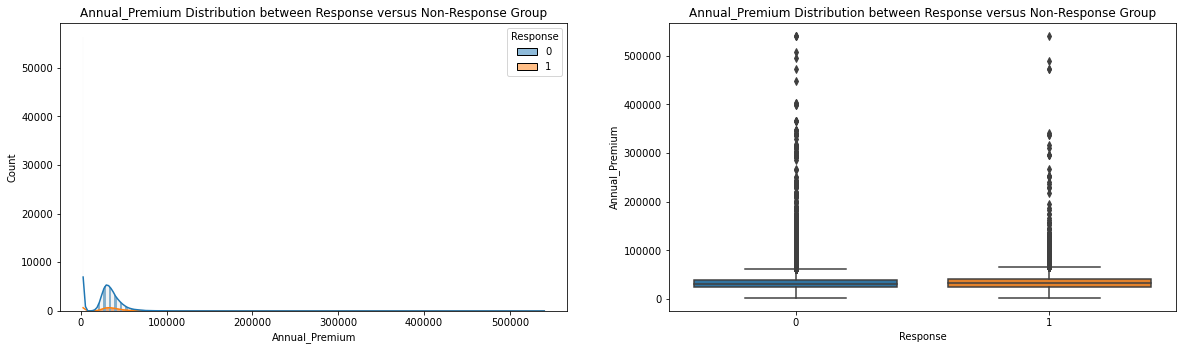

In [14]:
premium_df = df #removing the outliers of Annual_Premium
plt.figure(figsize=(20,18))
plt.subplots_adjust(wspace=0.2,hspace=0.2)

plt.subplot(3,2,1)
sns.histplot(data=premium_df, x='Annual_Premium', hue='Response',multiple='dodge', kde=True)
plt.title('Annual_Premium Distribution between Response versus Non-Response Group')
    
plt.subplot(3,2,2)
sns.boxplot(data=premium_df, x='Response', y='Annual_Premium')
plt.title('Annual_Premium Distribution between Response versus Non-Response Group')

In [15]:
df.groupby('Response')['Annual_Premium'].median().reset_index().rename(columns={'Annual_Premium': 'Median Annual_Premium'})

,Response,Median Annual_Premium
0,0,31504.0
1,1,33002.0


Distribution of Annual_Premium is rightly skewed due to outliers or extremely high annual_premium value of some policyholders. Although the median annual premium of 'interested' customer is slightly higher (33002) than 'not interested' customer (31504), the distribution of both groups seem to be overlapping. Therefore, no clear relationship between customer interest and annual_premium can be determined from the graph.

### Feature Engineering

#### Encode Categorical Data

In [3]:
#encode the categorical variables with 2 unique values
for col in [column for column in df.columns if df[column].nunique()==2]:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])
    print(col,':',dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

Gender : {'Female': 0, 'Male': 1}
Driving_License : {0: 0, 1: 1}
Previously_Insured : {0: 0, 1: 1}
Vehicle_Damage : {'No': 0, 'Yes': 1}
Response : {0: 0, 1: 1}


In [4]:
for column in ['Policy_Sales_Channel','Region_Code', 'Vehicle_Age']:
    print('Unique Class of {}: {}'.format(column,df[column].nunique()))

Unique Class of Policy_Sales_Channel: 155
Unique Class of Region_Code: 53
Unique Class of Vehicle_Age: 3


In [5]:
#encode the categorical variables > 2 unique values
df = pd.get_dummies(data=df, columns=['Vehicle_Age'],drop_first=True)

#rename column
df.rename(columns={'Vehicle_Age_< 1 Year':'Vehicle_Age_less_1_Year', 'Vehicle_Age_> 2 Years':'Vehicle_Age_More_2_Year'}, inplace=True)

<AxesSubplot:>

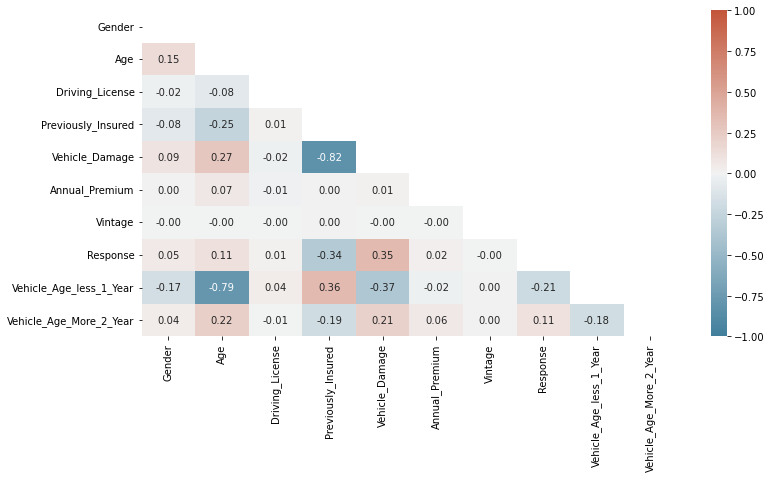

In [6]:
corr_df = df.drop(['id','Region_Code','Policy_Sales_Channel'],axis=1) #exclude id and non-dummy categorical variables for pearson's correlation
plt.figure(figsize=(12,6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_df.corr(), mask=np.triu(corr_df.corr()), annot = True, vmin=-1, vmax=1, cmap=cmap, fmt=".2f")

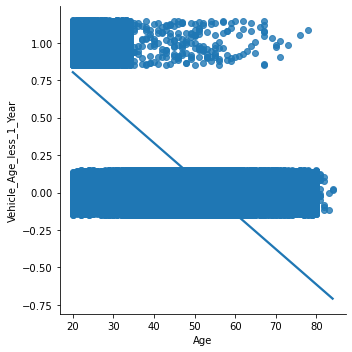

In [110]:
sns.lmplot('Age', 'Vehicle_Age_less_1_Year', data=X_train, y_jitter = .15)

In [113]:
pd.crosstab(df.Vehicle_Age_less_1_Year, df.Age)

Age,20,21,22,23,24,25,26,27,28,29,...,76,77,78,79,80,81,82,83,84,85
Vehicle_Age_less_1_Year,,,,,,,,,,,,,,,,,,,,,
0,423,663,575,507,528,461,495,618,832,1199,...,1393,1386,1214,915,907,56,29,22,11,11
1,5809,15794,20389,23749,25432,20175,13040,10142,8142,6230,...,3,2,2,0,2,0,0,0,0,0


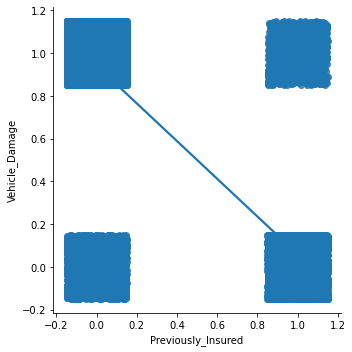

In [111]:
sns.lmplot('Previously_Insured', 'Vehicle_Damage', data=X_train, x_jitter = .15, y_jitter = .15)

In [112]:
pd.crosstab(df.Previously_Insured, df.Vehicle_Damage)

Vehicle_Damage,0,1
Previously_Insured,,
0,23990,182491
1,164706,9922


### Split Train-Test data

In [7]:
X = df.drop(['id','Response'],axis=1)
y = df['Response']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, 
                                                    stratify=y, shuffle=True, random_state=seed)

In [9]:
print('No. of training records: {}, No. of training features: {}'.format(X_train.shape[0],X_train.shape[1]))
print('No. of validation records: {}, No. of valication features: {}'.format(X_test.shape[0], format(X_test.shape[1])))

No. of training records: 304887, No. of training features: 11
No. of validation records: 76222, No. of valication features: 11


In [54]:
print(np.sum(y_train))
print(np.mean(y_test))

37368
0.12256303954238934


#### Before undersampling

In [10]:
def draw_matrix(y_pred):
    cf = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf, annot=True, annot_kws={"size": 10},fmt='d', cmap=plt.cm.Blues)
    plt.ylabel('Actual Response')
    plt.xlabel('Predicted Response')

Logistic Regression
Recall score for predicting class 1(customers who are interested):0.00


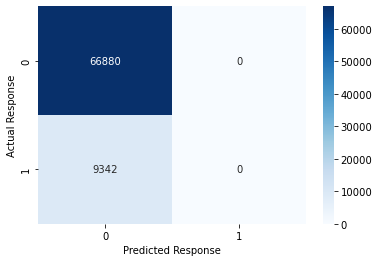

In [63]:
#Logistic Regression
Logistic_model = LogisticRegression()
Logistic_model.fit(X_train, y_train) 
y_pred = Logistic_model.predict(X_test)
print('Logistic Regression')
print('Recall score for predicting class 1(customers who are interested):{:.2f}'.format(recall_score(y_test, y_pred)))
draw_matrix(y_pred)

Decision Tree
Recall score for predicting class 1(customers who are interested):0.31


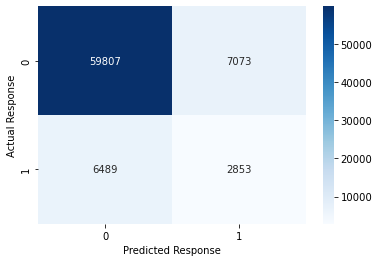

In [64]:
#Decision Tree 
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train) 
y_pred = DT_model.predict(X_test)
print('Decision Tree')
print('Recall score for predicting class 1(customers who are interested):{:.2f}'.format(recall_score(y_test, y_pred)))
draw_matrix(y_pred)

Random Forest
Recall score for predicting class 1(customers who are interested):0.12


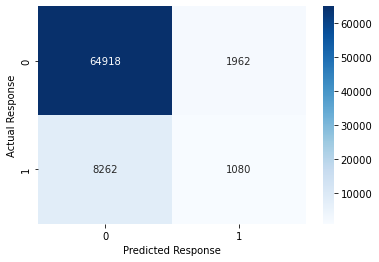

In [65]:
#Random Forest
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train) 
y_pred = RF_model.predict(X_test)
print('Random Forest')
print('Recall score for predicting class 1(customers who are interested):{:.2f}'.format(recall_score(y_test, y_pred)))
draw_matrix(y_pred)

#### Undersampling for train dataset

Percentage of target class 1(before Undersampling): 12.26%
Total training records before Undersampling: 304887
Percentage of target class 1(after Undersampling): 50.00%
Total training records after Undersampling: 74736


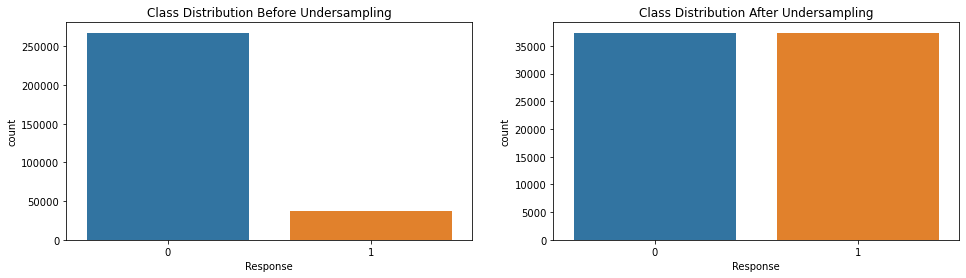

In [11]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.countplot(y_train)
plt.title('Class Distribution Before Undersampling')
print('Percentage of target class 1(before Undersampling): {:.2%}'.format(np.mean(y_train)))
print('Total training records before Undersampling: {}'.format(X_train.shape[0]))

under = RandomUnderSampler(random_state=seed)
X_train, y_train = under.fit_resample(X_train, y_train)

plt.subplot(1,2,2)
sns.countplot(y_train)
plt.title('Class Distribution After Undersampling')
print('Percentage of target class 1(after Undersampling): {:.2%}'.format(np.mean(y_train)))
print('Total training records after Undersampling: {}'.format(X_train.shape[0]))

### Hyperparameter Tuning using GridSearch

In [66]:
model = LogisticRegression()
param_grid = {'penalty': ['l2', 'l1'],
              'dual': [True, False],
              'class_weight': ['balanced', None],
              'max_iter' : [100,200,300,400]}
kfold=KFold(n_splits=10, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv = kfold, n_jobs=-1)
gridresult = grid.fit(X_train, y_train)
gridresult.best_estimator_

LogisticRegression(class_weight='balanced', max_iter=300)

In [93]:
model = DecisionTreeClassifier()
param_grid = {'criterion' : ['gini', 'entropy'], 
              'max_depth': [5,10,15]}
kfold=KFold(n_splits=10, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = kfold, n_jobs=-1)
gridresult = grid.fit(X_train, y_train)
gridresult.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [91]:
model = RandomForestClassifier()
param_grid = {'n_estimators': [5,10,15],
              'criterion': ['gini','entropy'],
              'max_depth': [5,10,15]}
kfold=KFold(n_splits=10, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = kfold, n_jobs=-1)
gridresult = grid.fit(X_train, y_train)
gridresult.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=15)

### Cross-Validation using Train Dataset

In [79]:
models = {'LR':LogisticRegression(max_iter=200), 
          'DT':DecisionTreeClassifier(criterion='entropy', max_depth=5), 
          'RF':RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=15)
         }
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

train_scores = []
names = []

for n,m in models.items():
    train_score = cross_val_score(m, X_train, y_train, cv=kfold, scoring='f1_macro')
    print('{} mean f1 score: {:.4f} (std: {:.4f})'.format(m,train_score.mean(),train_score.std()))
    train_scores.append(train_score)
    names.append(n)

LogisticRegression(max_iter=200) mean f1 score: 0.7342 (std: 0.0777)
DecisionTreeClassifier(criterion='entropy', max_depth=5) mean f1 score: 0.7878 (std: 0.0056)
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=15) mean f1 score: 0.7903 (std: 0.0055)


[Text(1, 0, 'LR'), Text(2, 0, 'DT'), Text(3, 0, 'RF')]

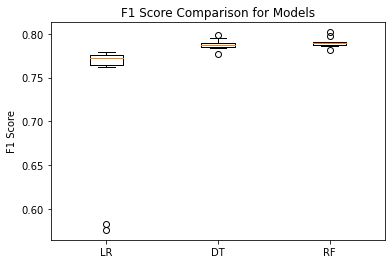

In [80]:
plt.boxplot(train_scores)
plt.title('F1 Score Comparison for Models')
plt.ylabel('F1 Score')
ax = plt.subplot()
ax.set_xticklabels(names)

### Validation Using Test Data

In [14]:
precision_scores=[]
recall_scores=[]
f1_scores=[]
f1_macro=[]
accuracy_scores=[]
models=[]

def score_model(model_name, trained_model):    
    y_pred = trained_model.predict(X_test)   
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    f1_macro.append(f1_score(y_test, y_pred, average='macro'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    models.append(model_name)
    print('{}:'.format(trained_model))
    print(classification_report(y_test, y_pred))

In [67]:
#Logistic Regression
# Logistic_model = LogisticRegression()
Logistic_model = LogisticRegression(class_weight='balanced', max_iter=200)
Logistic_model.fit(X_train, y_train) 
print(classification_report(y_train, Logistic_model.predict(X_train)))
# score_model('Logistic Regression_Test', Logistic_model)
score_model('Logistic Regression_Test(Tuned)', Logistic_model)

              precision    recall  f1-score   support

           0       0.57      0.65      0.61     37368
           1       0.59      0.51      0.55     37368

    accuracy                           0.58     74736
   macro avg       0.58      0.58      0.58     74736
weighted avg       0.58      0.58      0.58     74736

LogisticRegression(class_weight='balanced', max_iter=200):
              precision    recall  f1-score   support

           0       0.91      0.65      0.75     66880
           1       0.17      0.52      0.25      9342

    accuracy                           0.63     76222
   macro avg       0.54      0.58      0.50     76222
weighted avg       0.82      0.63      0.69     76222



/Users/Wiki/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Wiki/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [16]:
#Decision Tree 
# DT_model = DecisionTreeClassifier()
DT_model = DecisionTreeClassifier(criterion='entropy', max_depth=5)
DT_model.fit(X_train, y_train) 
print(classification_report(y_train, DT_model.predict(X_train)))
# score_model('Decision Tree_Test', DT_model)
score_model('Decision Tree_Test(Tuned)', DT_model)

              precision    recall  f1-score   support

           0       0.89      0.67      0.76     37368
           1       0.73      0.91      0.81     37368

    accuracy                           0.79     74736
   macro avg       0.81      0.79      0.79     74736
weighted avg       0.81      0.79      0.79     74736

DecisionTreeClassifier(criterion='entropy', max_depth=5):
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     66880
           1       0.28      0.91      0.43      9342

    accuracy                           0.70     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.70      0.75     76222



In [17]:
#Random Forest
# RF_model = RandomForestClassifier()
RF_model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=15)
RF_model.fit(X_train, y_train) 
print(classification_report(y_train, RF_model.predict(X_train)))
# score_model('Random Forest_test', RF_model)
score_model('Random Forest_Test(Tuned)', RF_model)

              precision    recall  f1-score   support

           0       0.92      0.66      0.77     37368
           1       0.74      0.94      0.83     37368

    accuracy                           0.80     74736
   macro avg       0.83      0.80      0.80     74736
weighted avg       0.83      0.80      0.80     74736

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=15):
              precision    recall  f1-score   support

           0       0.99      0.66      0.79     66880
           1       0.28      0.93      0.43      9342

    accuracy                           0.69     76222
   macro avg       0.63      0.79      0.61     76222
weighted avg       0.90      0.69      0.75     76222



In [18]:
print('Scores Comparison for Class 1 Prediction (Customers who are interested):')
pd.DataFrame({
    'Name': models,
    'Precision Score':[round(s,2) for s in precision_scores],
    'Recall Score':[round(s,2) for s in recall_scores],
    'F1 Score':[round(s,2) for s in f1_scores],
    'Accuracy Score':[round(s,2) for s in accuracy_scores],
    'F1 Macro':[round(s,2) for s in f1_macro]
})

Scores Comparison for Class 1 Prediction (Customers who are interested):


,Name,Precision Score,Recall Score,F1 Score,Accuracy Score,F1 Macro
0,Logistic Regression_Test(Tuned),0.17,0.52,0.25,0.63,0.50
1,Decision Tree_Test(Tuned),0.28,0.91,0.43,0.70,0.61
2,Random Forest_Test(Tuned),0.28,0.93,0.43,0.69,0.61


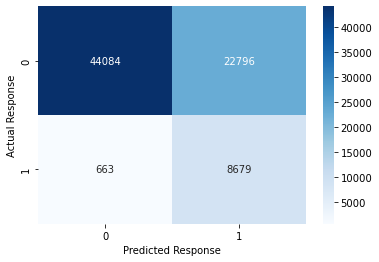

In [21]:
y_pred = RF_model.predict(X_test)
draw_matrix(y_pred)

#### Feature Importance

<AxesSubplot:>

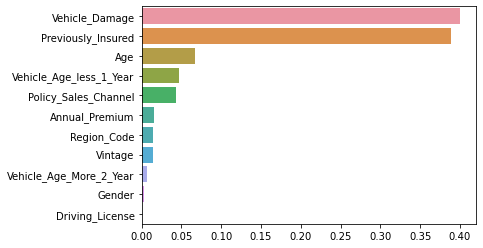

In [22]:
feature_name_sorted = []
feature_sorted = sorted(list(zip(RF_model.feature_names_in_,RF_model.feature_importances_)),key=lambda x: x[1], reverse=True)
for name,score in feature_sorted:
    feature_name_sorted.append(name)
    
sns.barplot(x=RF_model.feature_importances_ , y=X_train.columns, order=feature_name_sorted)

#### Predict

In [37]:
record = pd.DataFrame(
    {'Gender': [1], 
    'Age': [45], 
    'Driving_License':[1], 
    'Region_Code':[28], 
    'Previously_Insured':[0],
    'Vehicle_Damage':[1], 
    'Annual_Premium':[34678], 
    'Policy_Sales_Channel':[124], 
    'Vintage':[142],
    'Vehicle_Age_less_1_Year':[1], 
    'Vehicle_Age_More_2_Year':[0]}
)
print('LR prediction: Response will be {}'.format(Logistic_model.predict(record)))
print('DT prediction: Response will be {}'.format(DT_model.predict(record)))
print('RF prediction: Response will be {}'.format(RF_model.predict(record)))

LR prediction: Response will be [0]
DT prediction: Response will be [1]
RF prediction: Response will be [1]
